In [1]:
import getpass
import os

In [2]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGSMITH_API_KEY")

In [3]:
from typing import Annotated
import json

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import ToolMessage

from config import llm_gigachat


In [4]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [5]:
_set_env("TAVILY_API_KEY")
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_gigachat_with_tools = llm_gigachat.bind_tools(tools)

In [6]:
# tool.invoke("What's a 'node' in LangGraph?")

In [7]:

def chatbot(state: State):
    return {"messages": [llm_gigachat_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [8]:
class BasicToolNode():
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}
    
    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No massage found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])

graph_builder.add_node("tools", tool_node)

In [12]:
def route_tools(
        state: State,
):
    """
    Используйте в conditional_edge для маршрутизации к ToolNode, 
    если последнее сообщение имеет вызовы инструментов. 
    В противном случае маршрутизируйте к концу.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# Функция `tools_condition` возвращает "tools", если чат-бот просит использовать инструмент, 
# и "END", если он готов напрямую ответить. 
# Эта условная маршрутизация определяет основной цикл агента.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # Следующий словарь позволяет указать графу, что выходные данные условия следует интерпретировать как определенный узел.
    # По умолчанию используется функция идентификации, но если вы # хотите использовать узел с другим именем,
    # кроме "tools", Вы можете обновить значение словаря на что-то другое например, "tools": "my_tools"
    {"tools": "tools", END: END},
)

# graph_builder.add_conditional_edges(
#     "chatbot",
#     route_tools,
#     # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
#     # It defaults to the identity function, but if you
#     # want to use a node named something else apart from "tools",
#     # You can update the value of the dictionary to something else
#     # e.g., "tools": "my_tools"
#     {"tools": "tools", END: END},
# )

# Каждый раз, когда вызывается инструмент, мы возвращаемся к чат-боту, чтобы решить, что делать дальше.
graph_builder.add_edge("tools", "chatbot")

In [13]:
graph = graph_builder.compile()

ValueError: Found edge starting at unknown node '
    Следующий словарь позволяет указать графу, что выходные данные условия следует интерпретировать как определенный узел.
    По умолчанию используется функция идентификации, но если вы # хотите использовать узел с другим именем,
    кроме "tools", Вы можете обновить значение словаря на что-то другое например, "tools": "my_tools"
    chatbot'

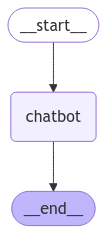

In [ ]:
from IPython.display import display, Image

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print("Рисунок не отображён")

In [18]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print(f"Assistant: {value['messages'][-1].content}")

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        user_input = "What do you know about LangGraph?"
        print(f"User: {user_input}")
        stream_graph_updates(user_input)
        break

Assistant: Hello! How can I assist you today?
Assistant: 4
Assistant: 4
Assistant: У меня нет доступа к реальному времени, поэтому я не могу точно сказать текущее время. Вы можете узнать его, посмотрев на часы вашего устройства или воспользовавшись функцией "Время" на вашем смартфоне или компьютере.
Assistant: Привет! Рад тебя видеть. Как твои дела?
Assistant: Первым человеком, совершившим полет в космос, стал Юрий Алексеевич Гагарин. Его исторический полет состоялся 12 апреля 1961 года на космическом корабле «Восток-1». Гагарин облетел Землю за 108 минут и стал настоящей легендой как для Советского Союза, так и для всего мира. Этот день теперь отмечается как День космонавтики в России и многих других странах.
Goodbye!
